In [11]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import shap

In [12]:
# Read the CSV file
df = pd.read_csv('/Users/student/Desktop/ANON36_HF_EKG_output.csv')

# change variable names
df = df.rename(columns={
    'Risk- Hypertension' : 'Hypertension',
    'Risk- Hypercholesteremia' : 'Hypercholesteremia', 
    'Risk- Hypertriglyceridemia' : 'Hypertriglyceridemia',
    'Risk- High HDL' : 'High HDL', 
    'Risk- Low HDL' : 'Low HDL', 
    'Risk- Diabetes' : 'Diabetes', 
    'Risk- Family Hx' : 'Family Hx',
    'Risk- Smoke' : 'Smoke', 
    'ASCVD PCE Risk Score' :'ASCVD PCE Risk',
    'PREVENT Score - ASCVD 10-year risk' : 'PREVENT ASCVD Risk', 
    'CVD PREVENT 10yr' : 'PREVENT CVD Risk',
    'HF PREVENT 10-year' : 'PREVENT HF Risk', 
    'Total A' : 'Total CAC Score', 
    'LM A' : 'CAC Score (Left Main)', 
    'LAD A' : 'CAC Score (LAD)', 
    'Cx' : 'CAC Score (LCx)', 
    'RCA' : 'CAC Score (RCA)',
    'Num Lesions' : 'Number of Total Lesions', 
    'Lesion Vol Sum' : 'Total Volume Score', 
    'Lesion Max D' : 'Peak CAC Density', 
    'Lesion Ave D' : 'Mean CAC Density', 
    'Male' : 'Gender',
    'Race_encoded' : 'Race',
})


In [13]:

# Select the columns
X = df.drop(['CONFIRM ID', 'result'], axis=1)
y = df['result']

# Make some columns categorical
categorical_cols = [X.columns[i] for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,45]]
for col in categorical_cols:
    X[col] = X[col].astype('category')

In [14]:

# Initialize StratifiedKFold for 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

# Create the XGBClassifier
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)

# Placeholder to store SHAP Explanation objects for each fold
all_shap_explanations = []

# Cross-validation loop with SHAP
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # Calculate SHAP values for the fold’s test set and store the entire Explanation object
    explainer = shap.Explainer(clf)
    shap_values_fold = explainer(X_test)
    
    # Store SHAP values and base values for each fold
    all_shap_explanations.append(shap_values_fold)

# After the for loop: Aggregate SHAP values across all folds

# Concatenate SHAP values from all folds
aggregated_shap_values = np.vstack([explanation.values for explanation in all_shap_explanations])

# Stack base values for each test set and calculate the mean along the sample axis
aggregated_base_values = np.mean(np.concatenate([explanation.base_values for explanation in all_shap_explanations]), axis=0)

# Concatenate the data points from all test sets
aggregated_data = np.vstack([X.iloc[test_index].values for _, test_index in cv.split(X, y)])

# Create a SHAP Explanation object with aggregated values
aggregated_shap_object = shap.Explanation(
    values=aggregated_shap_values,
    base_values=aggregated_base_values,
    data=aggregated_data,
    feature_names=X.columns
)

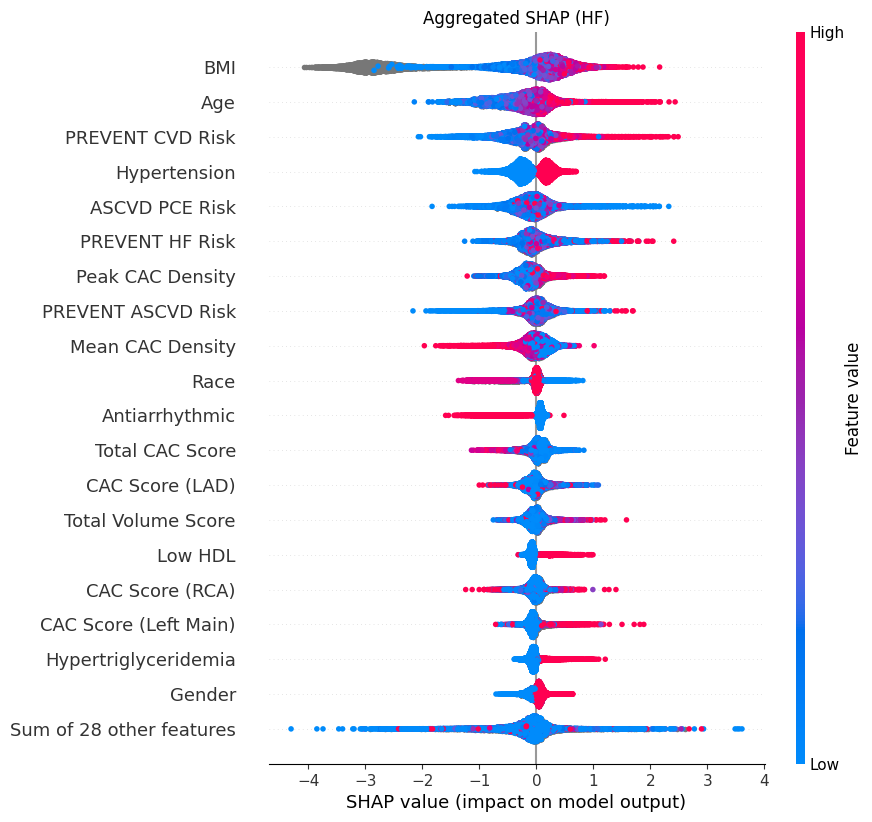

In [15]:
# Plot the aggregated SHAP values
plt.title('Aggregated SHAP (HF)')
shap.plots.beeswarm(aggregated_shap_object, max_display=20)
plt.show()